This practical is inspired from the Patho-Bench tutorial, which can be found __[here](https://github.com/mahmoodlab/Patho-Bench/blob/main/tutorial/tutorial.ipynb)__

⚠️ __Before you start this pratical, make sure to load the conda env for this pratical__

Run `source /data/Training-MG/files/data/AI_praticals_2025/MG_AI/bin/activate`

If you have not done so this morning, use ipykernel to access this env in the notebook
`ipykernel install --name MG_AI --display-name "Python (MG_AI)"`

and select the `Python (MG_AI)` kernel in your kernel list.

# Practical 2: Using the slide embeddings for downstream tasks

## Introduction
__Lung cancer and its major subtypes__

Lung cancer remains the leading cause of cancer-related death worldwide, responsible for approximately 1.8 million deaths each year (GLOBOCAN 2022). It encompasses several biologically distinct diseases, broadly divided into:

- Small-cell lung carcinoma (SCLC) — about 15% of cases, usually very aggressive and strongly associated with smoking.
- Non-small-cell lung carcinoma (NSCLC) — around 85% of cases, including:
    - Lung adenocarcinoma (LUAD)
    - Lung squamous cell carcinoma (LUSC)
      
Among them, LUAD is the most common subtype (≈40–50% of all lung cancers). It typically develops in the peripheral regions of the lungs and, although often associated with smoking, it also occurs in non-smokers, especially in women and in Asian populations. In contrast, LUSC usually arises in the central bronchi and shows a stronger correlation with heavy tobacco exposure.

Distinguishing LUAD from LUSC is a routine diagnostic task for pathologists using hematoxylin–eosin (H&E) stained slides. Their characteristic morphology (glandular structures in LUAD vs keratin pearls and intercellular bridges in LUSC) makes visual diagnosis relatively straightforward. Consequently, LUAD–LUSC classification is often used as a benchmark for computational pathology models, though it is an “easy task” for trained pathologists.

Now that we have seen how to compute slide embeddings, in this practical, we will go beyond this basic classification and explore more clinically meaningful applications of artificial intelligence in pathology using the slide embeddings obtained from [CPTAC-LUAD](https://www.cancerimagingarchive.net/collection/cptac-luad/) using two SOTA models: Titan and Feather.

## Data preparation
First, let's load Titan and Feather slide embeddings.

In [1]:
main_folder = "/data/Training-MG/files/data/AI_praticals_2025/AI_pratical_2_patho_bench"

In [2]:
import h5py
import pandas as pd

with h5py.File(f"{main_folder}/titan_embeddings.h5") as f:
    ids_titan = f['ids'].asstr()[:]
    features_titan = f['features'][:]
df_titan = pd.DataFrame({"slide_id": ids_titan, "titan_embeddings": features_titan.tolist()})

with h5py.File(f"{main_folder}/feather_embeddings.h5") as f:
    ids_feather = f['ids'].asstr()[:]
    features_feather = f['features'][:]
df_feather = pd.DataFrame({"slide_id": ids_feather, "feather_embeddings": features_feather.tolist()})

In [3]:
df_feather

,slide_id,feather_embeddings
0,C3L-00263-24,"[0.0, 0.0022216723300516605, 0.0, 0.4141846299..."
1,C3L-00422-22,"[0.0, 0.00234027742408216, 0.0, 0.097302652895..."
2,C3L-00279-22,"[0.0, 0.0018355874344706535, 0.0, 0.1186298578..."
3,C3N-00433-24,"[0.0, 0.0007690222118981183, 0.001675440696999..."
4,C3N-00217-22,"[0.0, 0.0033833233173936605, 0.002375862095504..."
...,...,...
321,C3N-01016-21,"[0.0, 0.004133278504014015, 0.0011857982026413..."
322,C3N-00551-24,"[0.0, 0.0003896531998179853, 5.505384979187511..."
323,C3L-00973-25,"[0.0, 0.0024305605329573154, 0.0, 0.6829251050..."
324,C3N-00556-24,"[0.0, 0.0003581818600650877, 0.007579792290925..."


In [4]:
df_titan

,slide_id,titan_embeddings
0,C3L-00263-24,"[0.89501953125, 1.0107421875, 0.6806640625, -0..."
1,C3L-00422-22,"[-0.05914306640625, 0.65673828125, 0.870117187..."
2,C3L-00279-22,"[1.185546875, 0.765625, 1.0166015625, 0.048370..."
3,C3N-00433-24,"[0.6875, 0.12054443359375, 0.17431640625, 0.50..."
4,C3N-00217-22,"[0.72021484375, 1.1484375, 0.8740234375, -0.53..."
...,...,...
321,C3N-01016-21,"[0.97412109375, 0.5, 0.822265625, -0.275878906..."
322,C3N-00551-24,"[0.81884765625, 0.338134765625, 0.377197265625..."
323,C3L-00973-25,"[0.05596923828125, 0.89208984375, 0.1854248046..."
324,C3N-00556-24,"[1.1533203125, 0.76220703125, -0.071533203125,..."


Now we will load the datasets that will be used for EGFR mutation and survival prediction

In [5]:
df_EGFR = pd.read_csv(f"{main_folder}/CPTAC_LUAD_EGFR_mutation.tsv", sep="\t")
EGFR_label_dict = {0: "wildtype", 1: "mutant"}
df_EGFR

,slide_id,EGFR_mutation,split
0,C3N-01074-21,0,train
1,C3N-01074-22,0,train
2,C3N-01074-23,0,train
3,C3N-01074-24,0,train
4,C3N-00556-23,0,train
...,...,...,...
319,C3N-02424-21,1,test
320,C3N-02424-22,1,test
321,C3L-01632-22,0,test
322,C3L-01632-21,0,test


In [6]:
df_OS = pd.read_csv(f"{main_folder}/CPTAC_LUAD_OS.tsv", sep="\t")
df_OS

,slide_id,OS_event,OS_days,OS,split
0,C3L-00001-21,0,1837,3,train
1,C3L-00009-21,1,577,6,train
2,C3L-00144-21,0,578,2,train
3,C3L-00279-22,0,606,2,train
4,C3L-00279-23,0,606,2,train
...,...,...,...,...,...
308,C3N-02002-23,0,355,0,test
309,C3N-02003-21,0,353,0,test
310,C3N-02003-22,0,353,0,test
311,C3N-02572-21,0,1135,3,test


Now, we will create two datasets: one for EGFR, one for OS. 
For each annotated slide id, the EGFR dataset will have to following columns:
- slide_id
- EGFR_mutation
- titan_embeddings
- feather_embeddings
- split
  
For each annotated slide id, the OS dataset will have to following columns:
- slide_id
- OS
- OS_event
- OS_days
- titan_embeddings
- feather_embeddings
- split

💡 Hint: You can use [pandas' merge method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) for this

In [7]:
df_EGFR = df_EGFR.merge(df_feather, how="left", on="slide_id").merge(df_titan, how="left", on="slide_id")
df_OS = df_OS.merge(df_feather, how="left", on="slide_id").merge(df_titan, how="left", on="slide_id")

In [8]:
df_EGFR

,slide_id,EGFR_mutation,split,feather_embeddings,titan_embeddings
0,C3N-01074-21,0,train,"[0.0, 0.0078019690699875355, 0.292257070541381...","[1.15625, 0.342041015625, 0.2020263671875, 0.0..."
1,C3N-01074-22,0,train,"[0.0, 0.000674330280162394, 0.0673696771264076...","[0.86962890625, 0.067626953125, 0.144653320312..."
2,C3N-01074-23,0,train,"[0.0, 0.029115865007042885, 0.0666604414582252...","[1.1044921875, 0.315185546875, 0.323486328125,..."
3,C3N-01074-24,0,train,"[0.0, 0.008429449051618576, 0.0696428865194320...","[0.99658203125, 0.21875, 0.030853271484375, 0...."
4,C3N-00556-23,0,train,"[0.0, 0.003753472352400422, 0.0015178077155724...","[0.83544921875, 0.32177734375, -0.27685546875,..."
...,...,...,...,...,...
319,C3N-02424-21,1,test,"[0.0, 0.0059347134083509445, 0.013033925555646...","[1.4970703125, 0.50830078125, -0.0328369140625..."
320,C3N-02424-22,1,test,"[0.0, 0.0043436940759420395, 0.034629128873348...","[1.361328125, 0.51708984375, -0.1895751953125,..."
321,C3L-01632-22,0,test,"[0.0, 0.0, 0.0, 0.2272881716489792, 9.64629089...","[0.325927734375, 0.828125, 0.60498046875, -0.5..."
322,C3L-01632-21,0,test,"[0.0, 1.8511174857849255e-05, 0.0, 0.266917526...","[0.60498046875, 0.8359375, 0.79296875, -0.4948..."


In [9]:
df_OS

,slide_id,OS_event,OS_days,OS,split,feather_embeddings,titan_embeddings
0,C3L-00001-21,0,1837,3,train,"[0.0, 0.002579029183834791, 0.0005420923698693...","[0.84130859375, 0.712890625, 0.8935546875, -0...."
1,C3L-00009-21,1,577,6,train,"[0.0, 0.0, 0.0, 1.4161404371261597, 1.99070636...","[0.5869140625, 0.8056640625, 0.703125, -0.0596..."
2,C3L-00144-21,0,578,2,train,"[0.0, 0.0, 0.0, 0.44096294045448303, 4.3898526...","[0.77294921875, 0.50732421875, 0.6435546875, 0..."
3,C3L-00279-22,0,606,2,train,"[0.0, 0.0018355874344706535, 0.0, 0.1186298578...","[1.185546875, 0.765625, 1.0166015625, 0.048370..."
4,C3L-00279-23,0,606,2,train,"[0.0, 0.0, 0.0, 0.15385611355304718, 0.1870028...","[0.8828125, 0.49658203125, 1.11328125, -0.4194..."
...,...,...,...,...,...,...,...
308,C3N-02002-23,0,355,0,test,"[0.0, 0.0, 0.0, 2.734670877456665, 0.001294365...","[0.642578125, 0.38525390625, 0.66064453125, 0...."
309,C3N-02003-21,0,353,0,test,"[0.0, 0.00012062200403306633, 0.03078229725360...","[0.79833984375, 0.83447265625, 0.38427734375, ..."
310,C3N-02003-22,0,353,0,test,"[0.0, 0.0006068293587304652, 0.006953551433980...","[0.64404296875, 0.78125, 0.427978515625, -0.46..."
311,C3N-02572-21,0,1135,3,test,"[0.0, 0.0, 0.0, 2.7416300773620605, 0.00141632...","[0.69482421875, 0.89697265625, 0.76904296875, ..."


## Unsupervised exploration
Let us first see if we can observe clusters for EGFR mutation and OS using Titan and Feather embeddings.
Using [scikit-learn's PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [seaborn's scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) compute the first two PCs of Titan and Feather embeddings. Then, for each embedding type, plot a graph showing EGFR mutated samples, and another showing the OS labels.

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
EGFR_titan_pcs = pca.fit_transform(np.array(df_EGFR.titan_embeddings.values.tolist()))
OS_titan_pcs = pca.fit_transform(np.array(df_OS.titan_embeddings.values.tolist()))
EGFR_feather_pcs = pca.fit_transform(np.array(df_EGFR.feather_embeddings.values.tolist()))
OS_feather_pcs = pca.fit_transform(np.array(df_OS.feather_embeddings.values.tolist()))

<Axes: >

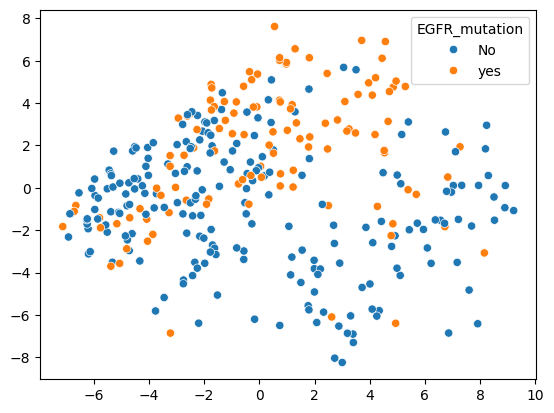

In [11]:
sns.scatterplot(x=EGFR_titan_pcs[:,0], y=EGFR_titan_pcs[:,1], hue=df_EGFR['EGFR_mutation'].map({0: 'No', 1: 'yes'}))

<Axes: >

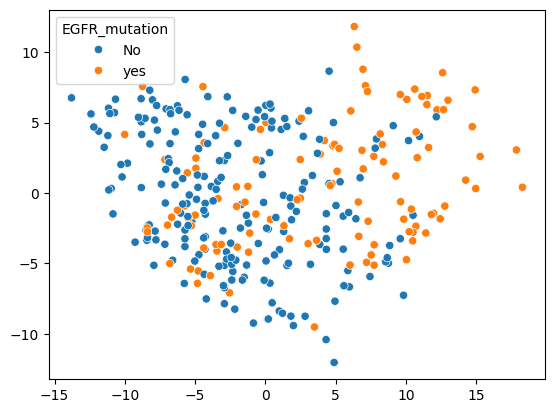

In [12]:
sns.scatterplot(x=EGFR_feather_pcs[:,0], y=EGFR_feather_pcs[:,1], hue=df_EGFR['EGFR_mutation'].map({0: 'No', 1: 'yes'}))

<Axes: >

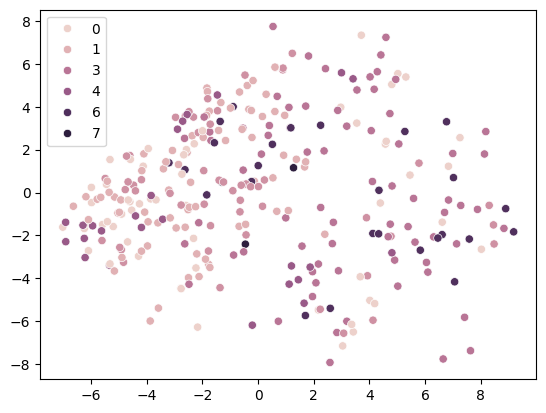

In [13]:
sns.scatterplot(x=OS_titan_pcs[:,0], y=OS_titan_pcs[:,1], hue=df_OS.OS.to_numpy())

<Axes: >

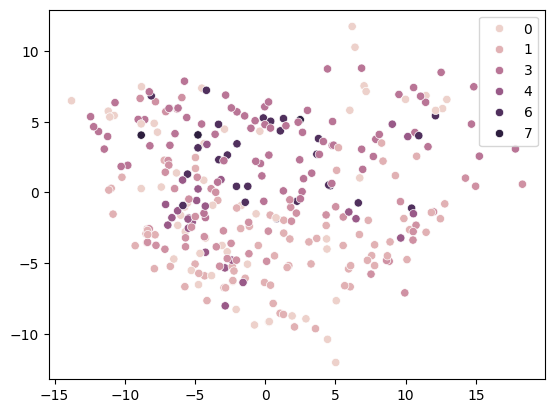

In [14]:
sns.scatterplot(x=OS_feather_pcs[:,0], y=OS_feather_pcs[:,1], hue=df_OS.OS.to_numpy())

- Do the two models provide similar embeddings? 
- Are there more outliers in one of the two models?
- Do you see some clusters appearing?

Given that the sample size is smaller than the number of slide embeddings' features, we will perform dimensionality reduction on our data before performing any downstream task to prevent overfitting. Add a `titan_pcs` and `feather_pcs` column to your EGFR and OS dataframes which will contain the first 10 PCs of each slide embedding.

In [15]:
pca = PCA(n_components=10)
df_EGFR["titan_pcs"] = pca.fit_transform(df_EGFR.titan_embeddings.values.tolist()).tolist()
df_EGFR["feather_pcs"] = pca.fit_transform(df_EGFR.feather_embeddings.values.tolist()).tolist()
df_OS["titan_pcs"] = pca.fit_transform(df_OS.titan_embeddings.values.tolist()).tolist()
df_OS["feather_pcs"] = pca.fit_transform(df_OS.feather_embeddings.values.tolist()).tolist()

## The importance of EGFR in lung adenocarcinoma
The EGFR gene (Epidermal Growth Factor Receptor) encodes a transmembrane receptor tyrosine kinase involved in cell proliferation, survival, and differentiation. Activating mutations in EGFR lead to continuous signaling through pathways such as MAPK and PI3K–AKT, promoting uncontrolled tumour growth. EGFR mutations occur in roughly 10–15% of LUAD cases in Western populations, and up to 40–50% in East Asian patients, and are more common in never-smokers (and in women and East-Asian populations) than in smokers (Ko 2022). There is also growing evidence that ambient air pollution (PM2.5) can promote EGFR-mutant LUAD in people who have never smoked (Hill et al., Nature 2023).

The discovery of EGFR mutations in the early 2000s revolutionized lung cancer therapy by introducing targeted treatments known as EGFR tyrosine kinase inhibitors (TKIs) (Lynch et al., NEJM 2004; Paez et al., Science 2004). These drugs — such as gefitinib, erlotinib, or osimertinib — block aberrant EGFR signaling and can lead to dramatic tumour shrinkage and prolonged survival compared with standard chemotherapy. First-line osimertinib (a 3rd-generation EGFR-TKI) has dramatically improved survival outcomes in EGFR-mutant lung adenocarcinoma. The FLAURA2 trial combining osimertinib + platinum-based chemotherapy reported a median OS of 47.5 months—nearly double the survival observed before the TKI era, when platinum chemotherapy alone yielded a median OS of 23.6 months (Maemondo et al., NEJM 2010; FLAURA2 WCLC 2025 abstract; AstraZeneca Press Release, 2025).

In clinical practice, EGFR status is typically determined through molecular testing (DNA sequencing, PCR, or next-generation sequencing). However, these tests require specialized equipment, time, and cost, and may not be available in all hospitals — particularly in low-resource settings.

Routine histology is available for every case. If AI could screen for EGFR mutation status directly from H&E:
- results could be fast and low-cost,
- triage could prioritize confirmatory molecular testing,
- and settings with limited molecular infrastructure could benefit sooner.

#### Logistic regression task
Using the EGFR dataset you just created, train one [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) model (more info [here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)) per slide embedding type using the slides' PCs and EGFR labels. Ten, evaluate the results using [scikit-learn's classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

💡 Hint: Use the `split` column to select the train and test set

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
random_state=42
y_train = df_EGFR[df_EGFR.split == "train"].EGFR_mutation.values.tolist()
y_test = df_EGFR[df_EGFR.split == "test"].EGFR_mutation.values.tolist()
X_train_feather = df_EGFR[df_EGFR.split == "train"].feather_pcs.values.tolist()
X_test_feather = df_EGFR[df_EGFR.split == "test"].feather_pcs.values.tolist()
X_train_titan =  df_EGFR[df_EGFR.split == "train"].titan_pcs.values.tolist()
X_test_titan =  df_EGFR[df_EGFR.split == "test"].titan_pcs.values.tolist()

clf = LogisticRegressionCV(cv=5, random_state=random_state).fit(X_train_feather, y_train)
y_pred_feather = clf.predict(X_test_feather)
print(classification_report(y_test, y_pred_feather, target_names=EGFR_label_dict.values()))
print(confusion_matrix(y_test, y_pred_feather))

              precision    recall  f1-score   support

    wildtype       0.73      0.92      0.81        38
      mutant       0.73      0.38      0.50        21

    accuracy                           0.73        59
   macro avg       0.73      0.65      0.66        59
weighted avg       0.73      0.73      0.70        59

[[35  3]
 [13  8]]


In [18]:
clf = LogisticRegressionCV(cv=5, random_state=random_state).fit(X_train_titan, y_train)
y_pred_titan = clf.predict(X_test_titan)
print(classification_report(y_test, y_pred_titan, target_names=EGFR_label_dict.values()))
print(confusion_matrix(y_test, y_pred_titan))

              precision    recall  f1-score   support

    wildtype       0.75      0.79      0.77        38
      mutant       0.58      0.52      0.55        21

    accuracy                           0.69        59
   macro avg       0.66      0.66      0.66        59
weighted avg       0.69      0.69      0.69        59

[[30  8]
 [10 11]]


- Do both slide embeddings performs the same? Is one better than the other?
- Highlight the incorrectly classified slides in a scatterplot using the first two PCs as x and y axis. Do the errors make sense? Why?
- **optional** Given these results, could you propose an ML algorithm which would work better? (💡 hint: you can check [this](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html))
- **optional** You can look at the thumbnails of the slides in the folder below to display incorrectly classified slides

Both models provide similar results. We can see on the scatterplot that incorrectly classified examples are generally in an overlapping part of the plot.

<Axes: >

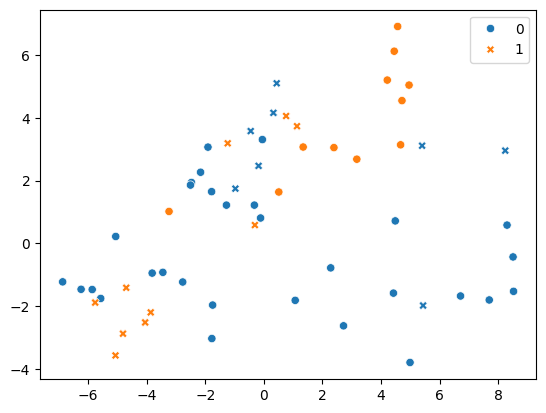

In [23]:
X = np.array(X_test_titan)
sns.scatterplot(x=X[:, 0], y=X[:,1], hue=y_test, style=(y_test != y_pred_titan))

<Axes: >

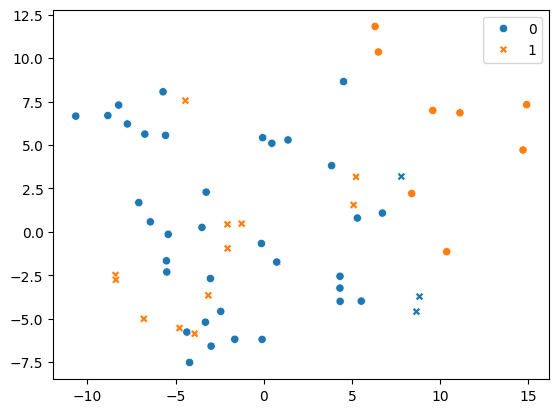

In [24]:
X = np.array(X_test_feather)
sns.scatterplot(x=X[:, 0], y=X[:,1], hue=y_test, style=(y_test != y_pred_feather))

In [ ]:
!ls /data/Training-MG/files/data/AI_praticals_2025/AI_pratical_2_patho_bench/CPTAC_LUAD_thumbnails/

Answer to the optional question: Given these results, could you propose an ML algorithm which would work better?

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
knn.fit(X_train_titan, y_train)
y_pred_titan_2 = knn.predict(X_test_titan)
print(classification_report(y_test, y_pred_titan_2, target_names=EGFR_label_dict.values()))
print(confusion_matrix(y_test, y_pred_titan_2))

              precision    recall  f1-score   support

    wildtype       0.85      0.89      0.87        38
      mutant       0.79      0.71      0.75        21

    accuracy                           0.83        59
   macro avg       0.82      0.80      0.81        59
weighted avg       0.83      0.83      0.83        59

[[34  4]
 [ 6 15]]


<Axes: >

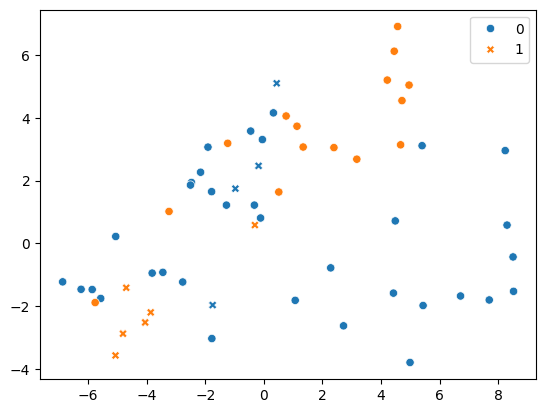

In [32]:
X = np.array(X_test_titan)
sns.scatterplot(x=X[:, 0], y=X[:,1], hue=y_test, style=(y_test != y_pred_titan_2))

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
knn.fit(X_train_feather, y_train)
y_pred_feather_2 = knn.predict(X_test_feather)
print(classification_report(y_test, y_pred_feather_2, target_names=EGFR_label_dict.values()))
print(confusion_matrix(y_test, y_pred_feather_2))

              precision    recall  f1-score   support

    wildtype       0.79      0.82      0.81        38
      mutant       0.65      0.62      0.63        21

    accuracy                           0.75        59
   macro avg       0.72      0.72      0.72        59
weighted avg       0.74      0.75      0.74        59

[[31  7]
 [ 8 13]]


<Axes: >

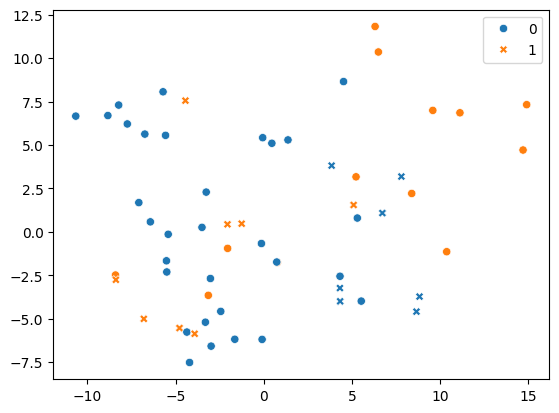

In [30]:
X = np.array(X_test_feather)
sns.scatterplot(x=X[:, 0], y=X[:,1], hue=y_test, style=(y_test != y_pred_feather_2))

## Predicting survival from histology
Beyond molecular alterations, a key clinical question is: how aggressive is this tumour?
Predicting patient survival or prognosis is central to treatment decisions. Current prognostic factors (tumour stage, grade, etc.) explain only part of the variability in outcomes.

WSIs encode tumour morphology, microenvironment, and spatial organization that correlate with prognosis. Recent advances in deep learning have demonstrated that AI models can extract subtle patterns from histology that correlate with survival, sometimes capturing signals beyond human perception (e.g., pan-cancer TCGA analysis: Wulczyn et al., PLOS ONE 2020).

#### Survival prediction task
Using our the OS dataframe, specifically the OS_days, OS_event, and PCs columns from the slide embeddings, train a [Cox proportional hazard model](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html) per slide embedding type, using [scikit-learn train test split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create a train and test dataset. Compute the concordance index of each model and plot the cumulative hazard and survival functions.

💡 Hint: you can find some examples [there](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html#sksurv.linear_model.CoxPHSurvivalAnalysis.score)

In [54]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
random_state = 42
df_OS = df_OS.astype({'OS_event': 'bool', 'OS_days': 'float'})
df_train = df_OS[df_OS.split == "train"]
df_test = df_OS[df_OS.split == "test"]
y_train = np.array(list(map(tuple, df_train[["OS_event", "OS_days"]].values)), dtype='bool, float')
y_test = np.array(list(map(tuple, df_test[["OS_event", "OS_days"]].values)), dtype='bool, float')
X_train_feather = df_train.feather_pcs.values.tolist()
X_test_feather = df_test.feather_pcs.values.tolist()
X_train_titan = df_train.titan_pcs.values.tolist()
X_test_titan = df_test.titan_pcs.values.tolist()

In [55]:
cox = CoxPHSurvivalAnalysis().fit(X_train_feather, y_train)
chf_funcs = cox.predict_cumulative_hazard_function(X_test_feather)
surv_funcs = cox.predict_survival_function(X_test_feather)
cox.score(X_test_feather, y_test)

np.float64(0.49876543209876545)

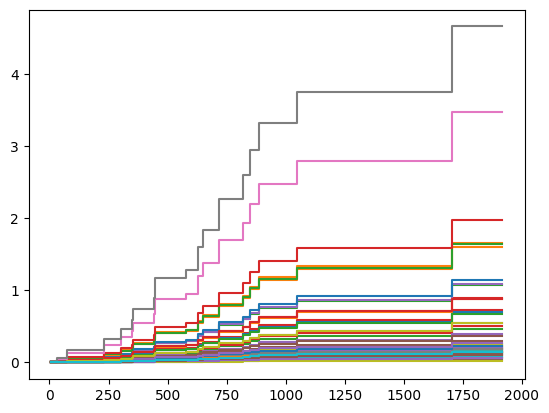

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(0)
for fn in chf_funcs:
    plt.step(fn.x, fn(fn.x), where="post")
plt.show()
fig.clf()

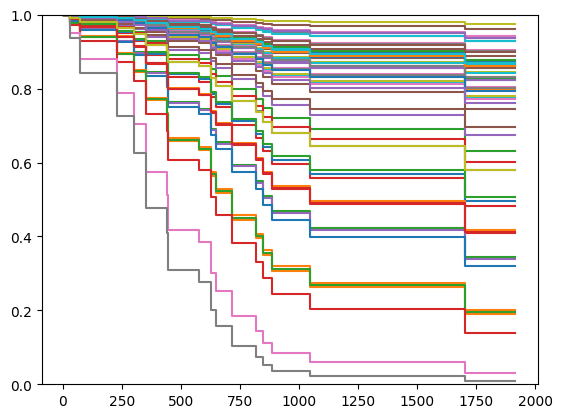

In [57]:
fig = plt.figure(0)
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1)
plt.show()
fig.clf()

In [58]:
cox = CoxPHSurvivalAnalysis().fit(X_train_titan, y_train)
chf_funcs = cox.predict_cumulative_hazard_function(X_test_titan)
surv_funcs = cox.predict_survival_function(X_test_titan)
cox.score(X_test_titan, y_test)

np.float64(0.5259259259259259)

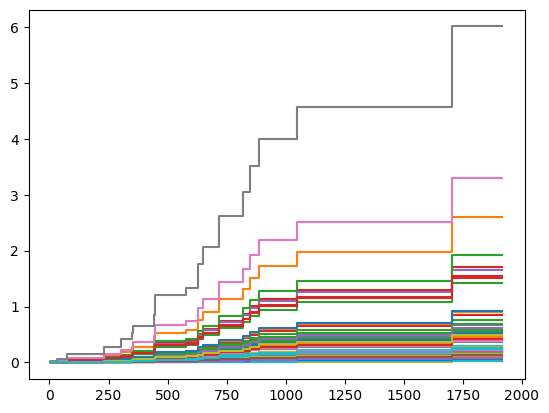

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure(0)
for fn in chf_funcs:
    plt.step(fn.x, fn(fn.x), where="post")
plt.show()
fig.clf()

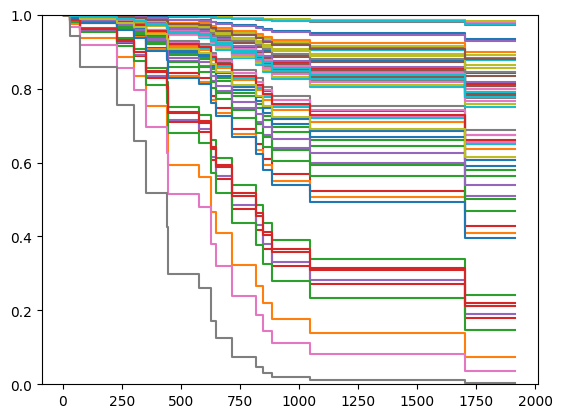

In [60]:
fig = plt.figure(0)
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1)
plt.show()
fig.clf()

- How good are the results?
- Is one model performing better than another?